In this notebook, we are going to train LSTM

We will start by Data Setup(Scaling and Sequencing)
Since Neural networks are sensitive, we must scale all data between 0 and 1.

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os

# 1. Load Data
PROCESSED_PATH = os.path.join("..", "data", "processed")
df = pd.read_csv(os.path.join(PROCESSED_PATH, "daily_sales_sentiment.csv"))
df['ds'] = pd.to_datetime(df['ds'])

# 2. Feature Selection
# We use SALES (y), SENTIMENT (sentiment_avg), and VOLUME (sales_volume)
features = ['y', 'sentiment_avg', 'sales_volume']
data = df[features].values

# 3. Scaling (Crucial for Neural Networks)
# LSTMs expect data between 0 and 1.
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 4. Create Sequences (The Logic Intensive Part)
# An LSTM doesn't look at "Today". It looks at "The Past 30 Days" to predict "Tomorrow".
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        # Input: Day i to Day i+29
        X.append(data[i:i+seq_length])
        # Target: The Sales (index 0) of Day i+30
        y.append(data[i+seq_length, 0]) 
    return np.array(X), np.array(y)

SEQ_LENGTH = 30  # Look back 30 days
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# 5. Split (Train/Test)
# We use the same split point as Prophet to make it a fair comparison
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to PyTorch Tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train).view(-1, 1)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test).view(-1, 1)

print(f"Training Shape: {X_train.shape}") # (Samples, 30, 3)
print(f"Testing Shape: {X_test.shape}")

Training Shape: torch.Size([547, 30, 3])
Testing Shape: torch.Size([137, 30, 3])


Now we define the Model architecture which is like the brain of the project.

In [4]:
class SalesLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SalesLSTM, self).__init__()
        self.hidden_size = hidden_size
        
        # The LSTM Layer
        # input_size = 3 (Sales, Sentiment, Volume)
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        
        # The Linear Layer (Prediction)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # Forward pass through LSTM
        # out shape: (batch_size, seq_length, hidden_size)
        out, _ = self.lstm(x)
        
        # We only care about the result of the LAST time step
        out = out[:, -1, :]
        
        # Pass through Linear layer to get the predicted sales
        out = self.fc(out)
        return out

# Initialize Model
input_size = 3  # We have 3 features
hidden_size = 64 # Number of neurons
output_size = 1 # Predicting 1 value (Sales)

model = SalesLSTM(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(model)

SalesLSTM(
  (lstm): LSTM(3, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


We now need to Train the Loop and this is where learning happens

Starting Training...
Epoch 0: Loss = 0.002333
Epoch 10: Loss = 0.002295
Epoch 20: Loss = 0.002269
Epoch 30: Loss = 0.002251
Epoch 40: Loss = 0.002240
Epoch 50: Loss = 0.002233
Epoch 60: Loss = 0.002227
Epoch 70: Loss = 0.002223
Epoch 80: Loss = 0.002218
Epoch 90: Loss = 0.002214
Epoch 100: Loss = 0.002210
Epoch 110: Loss = 0.002206
Epoch 120: Loss = 0.002201
Epoch 130: Loss = 0.002197
Epoch 140: Loss = 0.002193
Epoch 150: Loss = 0.002188
Epoch 160: Loss = 0.002184
Epoch 170: Loss = 0.002179
Epoch 180: Loss = 0.002174
Epoch 190: Loss = 0.002169


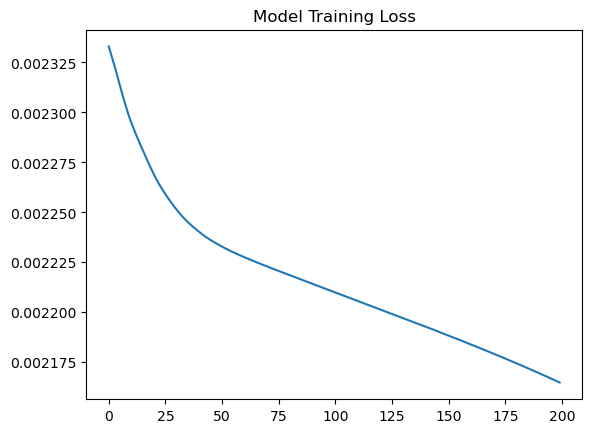

In [6]:
# Train the model
epochs = 200
loss_history = []

print("Starting Training...")
for i in range(epochs):
    # 1. Forward Pass
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    
    # 2. Backward Pass (Update Weights)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())
    
    if i % 10 == 0:
        print(f"Epoch {i}: Loss = {loss.item():.6f}")

# Plot Learning Curve
plt.plot(loss_history)
plt.title("Model Training Loss")
plt.show()

Model Evaluation: We will make predictions, inverse scale them and compare to prophet